# Feature extraction

### This notebook includes the functions to extract quantitative features from baseline PET/CT images, anatomical structure segmentation and tumor segmentation. The quantitative features mainly include;
1. Total metabolic tumor volume (TMTV): the metabolically active volume of the tumor segmented using FDG PET, the sum of tumoral voxels in $cm^3$
2. Maximum distance beween the largest lesion and another lesion (Dbulk) in cm 
3. Maximum distance tween two farthest lesions (Dmax) in cm 
4. Maximum distance between the spleen and another farthest lesion (DLS, later it will be named as Dspleen) in cm 
5. Standard deviation of the distances measured between the spleen and all other lesions (LS, later it will be named as SpreadSpleen) in cm
6. Spleen volume in $cm^3$
7. Splenic invasion or not (binary)  
8. Number of tumoral sites (Ntumors) 

In [1]:
"""
KB Girum
"""

# import library
import glob
import os

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import dicom2nifti
import dicom2nifti.settings as settings
import  csv


import nilearn
import nibabel as nib

import ray 
ray.init(log_to_driver=False, num_cpus=os.cpu_count())


2023-11-06 16:46:26,899	INFO worker.py:1528 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.7', ray_version='2.1.0', ray_commit='be49bde7ee4f6adb3f8710aee0665c27f9f0bb62', address_info={'node_ip_address': '10.150.10.32', 'raylet_ip_address': '10.150.10.32', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2023-11-06_16-46-25_131611_1207156/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2023-11-06_16-46-25_131611_1207156/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2023-11-06_16-46-25_131611_1207156', 'metrics_export_port': 62418, 'gcs_address': '10.150.10.32:60580', 'address': '10.150.10.32:60580', 'dashboard_agent_listen_port': 52365, 'node_id': '0cd1f8c036302a51a194e7bdf38439bff6fe56f5671cf7bf674a021f'})

In [2]:
""" Script to compute candidate image-based biomarkers from a given 3D mask images, PET, and segmented anatomical structures from CT images.
1. read .nii files
2. read the pixel spacing
3. compute candidate image-based biomakers including the total metabolic tumor volume (TMTV),
Compute the lesion dissemination (Dmax), and others biomarkers listed in the introduction above 
4. calculate the biomarkers in physical spacing, using the pixel spacing
6. save  in .CSV as columns of: patient name (anonymous), pixel_spaing, and the biomaerks' name 
"""

# import important libraries
from ast import Gt
from cmath import nan
from concurrent.futures.thread import _worker
from email.policy import default
from operator import index
import argparse
from numpy.random import seed
import operator

# library for dmax computation
from skimage.measure import label, regionprops
from skimage import data, util
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.spatial.distance import cosine

import pathlib
from pathlib import Path
import math 
import skimage 
import pandas as pd 
import scipy
from collections import defaultdict
from scipy.stats import spearmanr

# def sanity_check():
import nilearn.image
import time 
import nilearn

from scipy import ndimage



# concordance index of varaibles
from sksurv.metrics import (concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score)

In [3]:
"""Import functions developed to compute the quantitative radiomic features. 
"""
import utils.tumor_spread_and_dissemination_utils as TSDutil 
import utils.dspleen_preprocessing as preprocessing
import imp  

/tmp/ipykernel_1207156/158361392.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [4]:
# set properties of the figure to dispaly 
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
plt.rc("font", size=14)
sns.set(style="white")

In [ ]:
# Input directory to the spleen and tumor segmentations 
# =========================================================#
#input_dir = "/mnt/data/kgirum/Totalsegmenentator_or_moose/REMARC/"

# output directory to save the calculated features 
output_dir =  "../output/csv/"

# give a name to the csv file to be saved
data_id = 'extracted_quantitative_features_from_data_' + str(input_dir.split("/")[-2])

# load the script to calculate the quantitative radiomic features 
imp.reload(TSDutil)
Done_saving, nospleensegall = TSDutil.read_nii_pet_and_mask_compute_features_save_csv(input_dir, output_dir,  data_id=data_id)

In [6]:
Done_saving = pd.read_csv(Done_saving)

In [7]:
''' Preprocessing of the extract features including: 

'''
imp.reload(preprocessing)
data_id  = 'processed_data'
output_path  = '../output/csv/' # None
df = preprocessing.calcualte_features(df=Done_saving, data_id=data_id, output_path=output_path)

 11009101176010 no spleen detected 
Nan 11009101176010
 11009102186002 no spleen detected 
Nan 11009102186002
 61009711016044 no spleen detected 
Nan 61009711016044
Total number of patients correctly read and their volume calculated:  298
Calculated featured saved to the file directory: ../output/csv/processed_data_1699287567.822066_biomarker.csv !!


In [8]:
# Print the correlation between extracted features 
#print(df[biomarkers_cutoff_os_from_one_MIP].corr(min_periods=3, method='spearman')) # method  = "pearson"
df_corr = df.copy(deep=True)
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

In [9]:
print(f" ratio of splenic invasion: {df['spleen_lesion_overlap'].sum()/ len(df)}, and total cases: {len(df)}, and splenic invasion in {df['spleen_lesion_overlap'].sum()} casses")

 ratio of splenic invasion: 0.3389261744966443, and total cases: 298, and splenic invasion in 101 casses


In [10]:
# Clinical information 
df_clinical = pd.read_csv(r'../output/csv/clinical_info.csv')

# Combine the clincial data with the new bioamrkers 
df_clinical['id'] = df_clinical['id'].astype(str)



df_biomarkers = df.copy(deep=True)
df_biomarkers['id'] = df_biomarkers.index
df_biomarkers['id'] = df_biomarkers['id'].astype(str)


df_combined = df_clinical.merge(df_biomarkers,  on='id', how='inner')
df_combined = df_combined.set_index('id')

# # remove cases with no spleen segmentation 
remove_columns =  np.asarray(df_combined[df_combined['SpleenDetected'] == False].index)
df_combined = df_combined.drop(remove_columns)

print(df_combined.columns.tolist())

['Height (cm)', 'Weight (kg)', 'BSA', 'aaIPI', 'ecoge_status', 'stage', 'Sex', 'age', 'Maximum', 'TMTV (cm3) at baseline', 'PFS_event', 'PFS_months', 'OS_event', 'OS_months', 'Dmax_new', 'Dstd', 'Dbulk', 'Dbulk_std', 'DLS', 'x_dspleen', 'y_dspleen', 'z_dspleen', 'LS', 'rx_dspleen', 'ry_dspleen', 'rz_dspleen', 'xcenter_target', 'ycenter_target', 'zcenter_target', 'x_psize', 'y_psize', 'z_psize', 'TMTV', 'SpleenDetected', 'Ntumors', 'spleen_lesion_overlap', 'spleen_area']


In [11]:
# body surface area computed using sqrt ( (weight * height )/ 3600)
# weight should be in KG an height in cm
# the given distance were in cm then change to m, 1 m = 1 cm *0.001
df_combined['sDLS']  = ((df_combined['DLS']) / 
                        np.sqrt((df_combined['Weight (kg)'] * df_combined['Height (cm)'])/3600))
# df_combined['SDspleewn_spread']  = df_combined['Dspleen_spread'] /np.sqrt((df_combined['Weight (kg)'] * df_combined['Height (cm)'])/3600)*0.001
df_combined['SDmax']  = ((df_combined['Maximum']) / 
                         np.sqrt((df_combined['Weight (kg)'] * df_combined['Height (cm)'])/3600)) 
df_combined['SDbulk']  =  ((df_combined['Dbulk']) / 
                           np.sqrt((df_combined['Weight (kg)'] * df_combined['Height (cm)'])/3600))



In [12]:
df_combined.columns.tolist()

['Height (cm)',
 'Weight (kg)',
 'BSA',
 'aaIPI',
 'ecoge_status',
 'stage',
 'Sex',
 'age',
 'Maximum',
 'TMTV (cm3) at baseline',
 'PFS_event',
 'PFS_months',
 'OS_event',
 'OS_months',
 'Dmax_new',
 'Dstd',
 'Dbulk',
 'Dbulk_std',
 'DLS',
 'x_dspleen',
 'y_dspleen',
 'z_dspleen',
 'LS',
 'rx_dspleen',
 'ry_dspleen',
 'rz_dspleen',
 'xcenter_target',
 'ycenter_target',
 'zcenter_target',
 'x_psize',
 'y_psize',
 'z_psize',
 'TMTV',
 'SpleenDetected',
 'Ntumors',
 'spleen_lesion_overlap',
 'spleen_area',
 'sDLS',
 'SDmax',
 'SDbulk']

In [13]:
df_combined_copy = df_combined.copy(deep=True)

df_combined.rename(columns={'TMTV (cm3) at baseline':'TMTV2',
                            "Dmax_new":"Dmax", 
                           'aaIPI':'IPI',
                            "spleen_lesion_overlap":"splenic_invasion", 
                           'sDLS':"sDspleen",
                           'DLS':"Dspleen",
                           'LS':"SpreadSpleen"}, inplace=True)

In [14]:

select_features  = ['TMTV',
                    'Dmax', 
                    'IPI', 
                    "splenic_invasion",
                     'PFS_event',
                     'PFS_months',
                     'OS_event',
                     'OS_months',
                     'Dbulk',
                     'sDspleen',
                     'SpreadSpleen',
                     'Ntumors',
                     'Dspleen'
                                       ]


df_combined = df_combined[select_features]

In [15]:
print (df_combined.columns[df_combined.columns.duplicated(keep=True)])

Index([], dtype='object')


In [ ]:
df_combined.style.hide_index()

In [1]:
#

In [17]:
# # compute correlation between selected features 
# biomarkers_cutoff_os_from_one_MIP = []
# for clm in df_combined.columns:
#     if  str(clm).split('_')[0].lower() not in ['pfs', 'os']:
#         biomarkers_cutoff_os_from_one_MIP.append(clm)
        
# df_corr = df_combined[biomarkers_cutoff_os_from_one_MIP].copy()
# corr = df_corr.corr()
# corr.style.background_gradient(cmap='coolwarm')

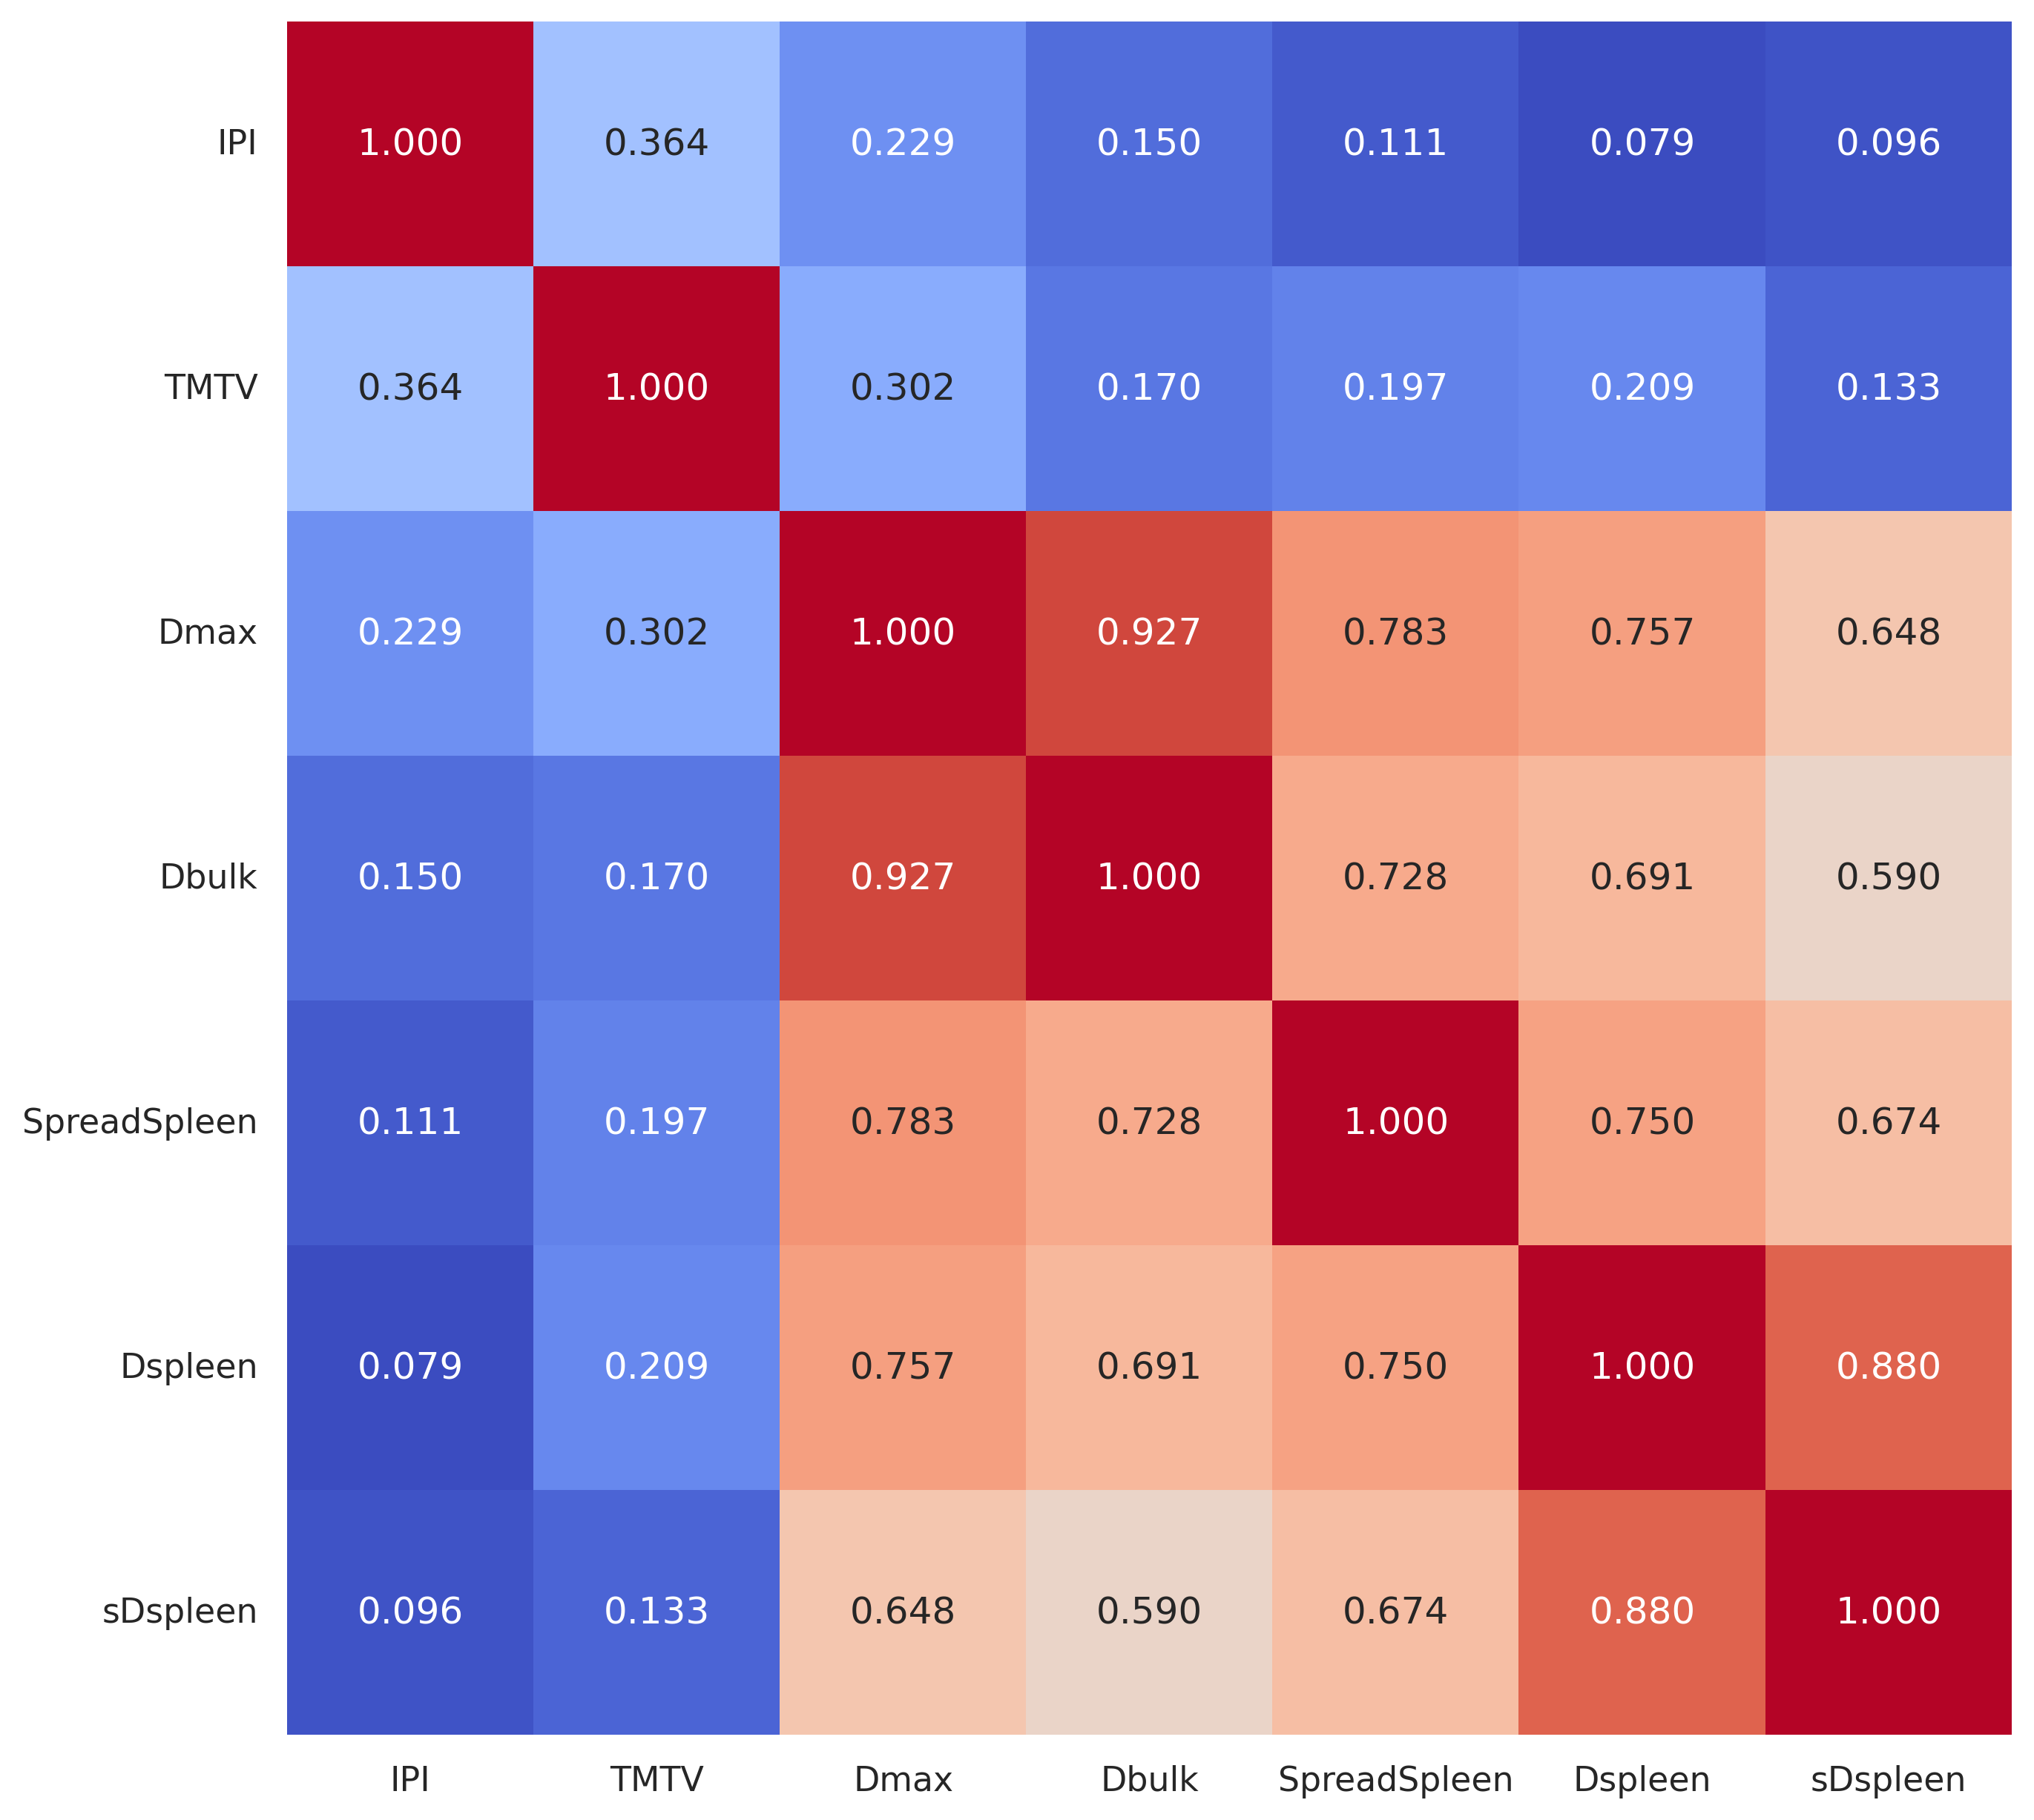

In [18]:
matrix  = ['IPI', 'TMTV', "Dmax", 'Dbulk', 'SpreadSpleen', 'Dspleen', 'sDspleen']
df_corr = df_combined[matrix].copy()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt='.3f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig(r'../output/correlation_result.png', bbox_inches='tight', pad_inches=0.0)

plot the concordance index from each features 

	 OS 	
c_harrel of IPI is (0.6093920145190562, 4722, 2311, 3987, 5)
c_harrel of TMTV is (0.661978221415608, 7295, 3725, 0, 5)
c_harrel of Dmax is (0.6000453720508166, 6604, 4399, 17, 5)
c_harrel of Dbulk is (0.6026769509981851, 6633, 4370, 17, 5)
c_harrel of SpreadSpleen is (0.6269963702359347, 6901, 4102, 17, 5)
c_harrel of Dspleen is (0.6348457350272232, 6996, 4024, 0, 5)
c_harrel of sDspleen is (0.6408348457350272, 7062, 3958, 0, 5)
defaultdict(<class 'list'>, {'target': ['OS', 'OS', 'OS', 'OS', 'OS', 'OS', 'OS'], 'features': ['IPI', 'TMTV', 'Dmax', 'Dbulk', 'SpreadSpleen', 'Dspleen', 'sDspleen'], 'c-index': [0.6093920145190562, 0.661978221415608, 0.6000453720508166, 0.6026769509981851, 0.6269963702359347, 0.6348457350272232, 0.6408348457350272]})
	 PFS 	
c_harrel of IPI is (0.5871184811343427, 6725, 3825, 6094, 12)
c_harrel of TMTV is (0.657293919730834, 10940, 5704, 0, 12)
c_harrel of Dmax is (0.632209805335256, 10507, 6106, 31, 12)
c_harrel of Dbulk is (0.6189317471761596, 10286,

<Figure size 3000x6000 with 0 Axes>

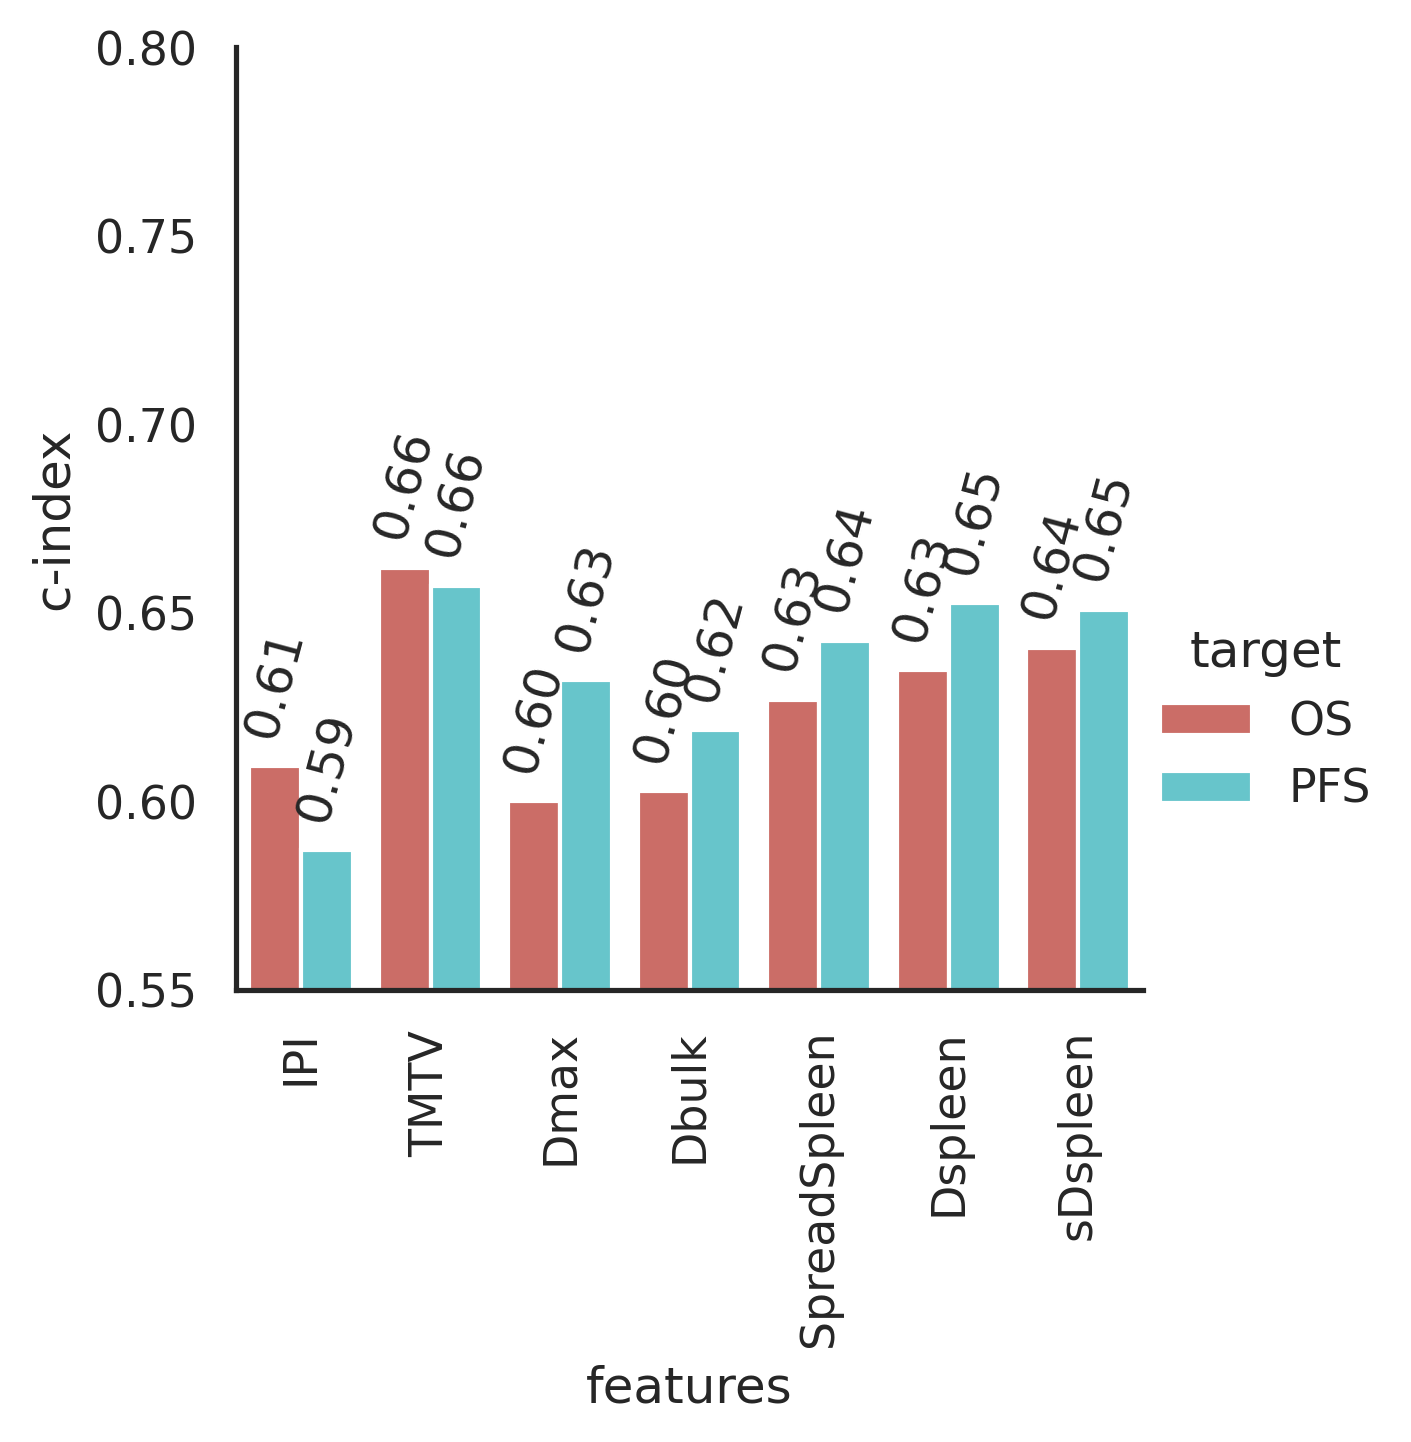

In [19]:
matrix  = ['IPI', 'TMTV', "Dmax", 'Dbulk', 'SpreadSpleen', 'Dspleen', 'sDspleen']

data = defaultdict(list)

for os_pfs in ['OS', "PFS"]:
    print(20*"==")
    print(f"\t {os_pfs} \t")
    print(20*"==")
    for biomarker in matrix:    
        y = defaultdict(list)
        y['event'] = df_combined[str(os_pfs)+'_event'].values
        y['event'] = (y['event'] >=1)
        y['time'] = df_combined[str(os_pfs)+'_months'].values

        x = (df_combined[biomarker].values).reshape(-1, 1)
        x =  (x - np.mean(x))/(np.std(x) + 1e-8)
        x= np.squeeze(x)
        c_harrell = concordance_index_censored(y['event'], y['time'], x)
        print(f"c_harrel of {biomarker} is {c_harrell}")
        data['target'].append(os_pfs)
        data['features'].append(biomarker)
        data['c-index'].append(c_harrell[0])

    print(data)

data = pd.DataFrame(data)




data.head()
plt.figure(figsize=(10
                    , 20))
g = sns.catplot(x="features", y="c-index",
                hue='target', 
                data=data, kind="bar",
                height=4, aspect=1, palette='hls');


for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 20), textcoords = 'offset points',  rotation=75,
        
                   )
plt.xticks(rotation=90)
plt.ylim([0.55, 0.8])
# # plt.savefig("TMTV.png")
plt.rcParams.update({'font.size':9})

In [20]:
# Statistical properity of the data
df_combined.describe()

TMTV        Dmax         IPI  splenic_invasion   PFS_event  \
count   285.000000  285.000000  285.000000         285.00000  285.000000   
mean    433.069236   40.294772    1.652632           0.34386    0.301754   
std     577.153932   23.841254    0.733049           0.47583    0.459827   
min       0.342288    0.000000   -1.000000           0.00000    0.000000   
25%      78.652940   20.440136    1.000000           0.00000    0.000000   
50%     238.903197   41.017839    2.000000           0.00000    0.000000   
75%     536.397279   61.938822    2.000000           1.00000    1.000000   
max    3830.400000   90.624496    3.000000           1.00000    1.000000   

       PFS_months    OS_event   OS_months       Dbulk    sDspleen  \
count  285.000000  285.000000  285.000000  285.000000  285.000000   
mean    32.793684    0.171930   46.460351   31.698811   17.608608   
std     18.400114    0.377983   20.235708   18.553788    5.431604   
min      0.000000    0.000000    0.000000    0.000000    4.897697   
25%     18.400000    0.000000   32.400000   15.737568   13.857853   
50%     32.200000    0.000000   47.000000   31.776103   18.086329   
75%     47.800000    0.000000   61.400000   44.402782   21.291638   
max     74.100000    1.000000   86.900000   90.624496   44.147856   

       SpreadSpleen     Ntumors     Dspleen  
count    285.000000  285.000000  285.000000  
mean       6.327848   19.663158   32.096759  
std        3.024746   21.190423    9.580046  
min        0.000000    1.000000    9.053015  
25%        4.036144    5.000000   25.971966  
50%        6.689746   12.000000   32.480230  
75%        8.444140   27.000000   38.741072  
max       13.708880  132.000000   62.389219